In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchsummary import summary # 디버깅 쉽게 해줌

import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST

from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Project running on device: ", DEVICE)

# configurations for the task
config = {
    "batch_size": 64,
    "epochs": 3,
    "lr": 5e-4,   # learning rate
}


Project running on device:  cuda


In [2]:
def collate_fn(batch):
    process = transforms.Compose([
                transforms.ToTensor(),
                transforms.Pad([2])]
                )
 
    # x - images; we process each image in the batch
    x = [process(data[0]) for data in batch]
    x = torch.concat(x).unsqueeze(1)
    
    # y - labels, note that we should convert the labels to LongTensor
    y = torch.LongTensor([data[1] for data in batch])

    return x, y

In [3]:
labels = ["T-shirt/top", 
          "Trouser", 
          "Pullover", 
          "Dress", 
          "Coat", 
          "Sandla", 
          "Shirt", 
          "Sneaker", 
          "Bag", 
          "Ankle boot"]

# download/load dataset
train_data = FashionMNIST("./MNIST_DATA", train=True, download=True)
valid_data = FashionMNIST("./MNIST_DATA", train=False, download=True)

# put datasets into dataloaders
train_loader = DataLoader(train_data, batch_size=config["batch_size"], 
                          shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=config["batch_size"], 
                           shuffle=False, collate_fn=collate_fn)

Inspecting train data: 
Batch shape:  torch.Size([64, 1, 32, 32])


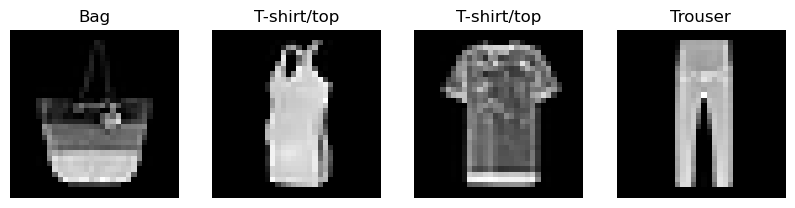

In [4]:
print("Inspecting train data: ")
for _, data in enumerate(train_loader):
    print("Batch shape: ", data[0].shape)
    fig, ax = plt.subplots(1, 4, figsize=(10, 4))

    for i in range(4):
        # Ture 3D tensor to 2D tensor due to image's single channel
        ax[i].imshow(data[0][i].squeeze(), cmap="gray")
        ax[i].axis("off")
        ax[i].set_title(labels[data[1][i]])
    plt.show()
    # And don't forget to break
    break

In [5]:
# Model parameters:
LAYERS = 3
KERNELS = [3, 3, 3]
CHANNELS = [32, 64, 128]
STRIDES = [2, 2, 2]
LINEAR_DIM = 2048

In [6]:
class Encoder(nn.Module):
    def __init__(self, output_dim=2, use_batchnorm=False, use_dropout=False):
        super(Encoder, self).__init__()

        # bottleneck dimentionality
        self.output_dim = output_dim

        # variables deciding if using dropout and batchnorm in model
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        # convolutional layer hyper parameters
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS
        self.strides = STRIDES
        self.conv = self.get_convs()

        # layers for latent space projection
        self.fc_dim = LINEAR_DIM
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(self.fc_dim, self.output_dim)

    def get_convs(self):
        conv_layers = nn.Sequential()
        for i in range(self.layers):
            # input channel of the first layer is 1
            if i == 0:
                conv_layers.append(nn.Conv2d(
                    1, 
                    self.channels[i],
                    kernel_size=self.kernels[i],
                    padding=1
                ))
            else:
                conv_layers.append(nn.Conv2d(
                    self.channels[i-1],
                    self.channels[i],
                    kernel_size=self.kernels[i],
                    stride=self.strides[i],
                    padding=1
                ))
            if self.use_batchnorm:
                conv_layers.append(nn.BatchNorm2d(self.channels[i]))
            
            conv_layers.append(nn.GELU())

            if self.use_dropout:
                conv_layers.append(nn.Dropout2d(0.15))
        
        return conv_layers
    
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        return self.linear(x)


In [7]:
class Decoder(nn.Module):
    
    def __init__(self, input_dim=2, use_batchnorm=False, use_dropout=False):
        
        super(Decoder, self).__init__()
        
        # variables deciding if using dropout and batchnorm in model
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm

        self.fc_dim = LINEAR_DIM
        self.input_dim = input_dim
        
        # Conv layer hypyer parameters
        self.layers = LAYERS
        self.kernels = KERNELS
        self.channels = CHANNELS[::-1] # flip the channel dimensions
        self.strides = STRIDES
        
        # In decoder, we first do fc project, then conv layers
        self.linear = nn.Linear(self.input_dim, self.fc_dim)
        self.conv =  self.get_convs()

        self.output = nn.Conv2d(self.channels[-1], 1, kernel_size=1, stride=1)

    def get_convs(self):
        conv_layers = nn.Sequential()
        for i in range(self.layers):
            
            if i == 0: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i],
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1)
                            )
            
            else: conv_layers.append(
                            nn.ConvTranspose2d(self.channels[i-1], 
                                               self.channels[i],
                                               kernel_size=self.kernels[i],
                                               stride=self.strides[i],
                                               padding=1,
                                               output_padding=1
                                              )
                            )
            
            if self.use_batchnorm and i != self.layers - 1:
                conv_layers.append(nn.BatchNorm2d(self.channels[i]))

            conv_layers.append(nn.GELU())

            if self.use_dropout:
                conv_layers.append(nn.Dropout2d(0.15))

        return conv_layers
    
    
    def forward(self, x):
        x = self.linear(x)
        # reshape 3D tensor to 4D tensor
        x = x.reshape(x.shape[0], 128, 4, 4)
        x = self.conv(x)
        return self.output(x)

In [8]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(output_dim=2, 
                               use_batchnorm=True, use_dropout=False)
        self.decoder = Decoder(input_dim=2,
                               use_batchnorm=True, use_dropout=False)
        
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [9]:
def plotting(step:int=0, show=False):
    
    model.eval() # Switch the model to evaluation mode
    
    points = []
    label_idcs = []
    
    path = "./ScatterPlots"
    if not os.path.exists(path): os.mkdir(path)
    
    for i, data in enumerate(valid_loader):
        img, label = [d.to(DEVICE) for d in data]
        # We only need to encode the validation images
        proj = model.encoder(img)
        points.extend(proj.detach().cpu().numpy())
        label_idcs.extend(label.detach().cpu().numpy())
        del img, label
    
    points = np.array(points)
    
    # Creating a scatter plot
    fig, ax = plt.subplots(figsize=(10, 10) if not show else (8, 8))
    scatter = ax.scatter(x=points[:, 0], y=points[:, 1], s=2.0, 
                c=label_idcs, cmap='tab10', alpha=0.9, zorder=2)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    if show: 
        ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
        plt.show()
    else: 
        # Do not show but only save the plot in training
        plt.savefig(f"{path}/Step_{step:03d}.png", bbox_inches="tight")
        plt.close() # don't forget to close the plot, or it is always in memory
        model.train()

# convert image sequence to a gif file
def save_gif():
  
  frames = []
  imgs = sorted(os.listdir("./ScatterPlots"))

  for im in imgs:
      new_frame = Image.open("./ScatterPlots/" + im)
      frames.append(new_frame)
  
  frames[0].save("latentspace.gif", format="GIF",
                 append_images=frames[1:],
                 save_all=True,
                 duration=200, loop=0)

In [10]:
# training
model=AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=1e-5)

# For mixed precision training
scaler = torch.cuda.amp.GradScaler()
steps = 0 # tracking the training steps

In [11]:
def train(model, dataloader, criterion, optimizer, save_distrib=False):
    # steps is used to track training progress, purely for latent space plots
    global steps 
    
    model.train()
    train_loss = 0.0
    
    # Process tqdm bar, helpful for monitoring training process
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, 
                     leave=False, position=0, desc="Train")

    for i, batch in enumerate(dataloader):
        
        optimizer.zero_grad()
        x = batch[0].to(DEVICE)
        
        # Here we implement the mixed precision training
        with torch.cuda.amp.autocast():
            y_recons = model(x)
            loss = criterion(y_recons, x)
        
        train_loss += loss.item()
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        batch_bar.set_postfix(
            loss=f"{train_loss/(i+1):.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )
        batch_bar.update()        

        # Saving latent space plots
        if steps % 10 == 0 and save_distrib and steps <= 400: plotting(steps)
        steps += 1        
        
        # remove unnecessary cache in CUDA memory
        torch.cuda.empty_cache()
        del x, y_recons
    
    batch_bar.close()
    train_loss /= len(dataloader)

    return train_loss

In [12]:
def validate(model, dataloader, criterion):
    
    model.eval() # Don't forget to turn the model to eval mode
    valid_loss = 0.0
    
    # Progress tqdm bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True,
                     leave=False, position=0, desc="Validation")
    
    for i, batch in enumerate(dataloader):
        x = batch[0].to(DEVICE)
        
        with torch.no_grad(): # we don't need gradients in validation
            y_recons = model(x)
            loss = criterion(y_recons, x)
        
        valid_loss += loss.item()
        
        batch_bar.set_postfix(
            loss=f"{valid_loss/(i+1):.4f}",
            lr = f"{optimizer.param_groups[0]['lr']:.4f}"
        )
        batch_bar.update()
        
        torch.cuda.empty_cache()
        del x, y_recons
    
    batch_bar.close()
    valid_loss /= len(dataloader)
    
    return valid_loss

In [13]:
for i in range(config["epochs"]):

    curr_lr = float(optimizer.param_groups[0]["lr"])
    train_loss = train(model, train_loader, criterion, 
                       optimizer, save_distrib=True)
    valid_loss = validate(model, valid_loader, criterion)

    print(f"Epoch {i+1}/{config['epochs']}\nTrain loss: {train_loss:.4f}\t Validation loss: {valid_loss:.4f}\tlr: {curr_lr:.4f}")


Train:   0%|          | 0/938 [00:00<?, ?it/s]

RuntimeError: Input type (struct c10::Half) and bias type (float) should be the same